# Install libraries

In [0]:
# pip install "dask[complete]"

# Import packages

In [0]:
import math
import os
import json
from typing import Dict, List, Tuple

# import dask.array as da
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import torch
from torch.nn.functional import normalize
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet50
from torchvision import transforms as tvt
from tqdm import tqdm

torch.manual_seed(0)
np.random.seed(0)

# Set paths

In [0]:
data_path = "/dbfs/fashionpedia/images/test"
model_path = "/dbfs/imseg/base"
out_path = "/dbfs/imseg/imsearch"

# Load model

In [0]:
model = torch.load(os.path.join(model_path, "segm.pth"),
                   map_location=torch.device('cpu'))
model.eval();

# Get images

In [0]:
file_list = [file for file in os.listdir(data_path) if file.endswith(".jpg")]
print(len(file_list))

3200

# Create Dataset

In [0]:
class ImSegDataset(Dataset):
    """Custom class for Image segmentation dataset
    Args:
        root: Directory containing the dataset
        img_paths: Paths of the images relative to the root
    """

    def __init__(self, root: str, img_paths: List[str]) -> None:
        self.root = root
        self.img_paths = img_paths
        self.transforms = tvt.ToTensor()

    def __getitem__(self, idx: int) -> Image.Image:
        """Get an item from the dataset given the index idx"""
        im_path = os.path.join(self.root, self.img_paths[idx])
        img = Image.open(im_path).convert("RGB")
        img = self.transforms(img)

        return img

    def __len__(self) -> int:
        """Length of the dataset"""
        return len(self.img_paths)

In [0]:
inp_ds = ImSegDataset(data_path, file_list)

d_l = DataLoader(
    inp_ds,
    batch_size=2,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
    collate_fn=list
)

# Utility functions

In [0]:
def vis_data(img: np.ndarray,
             target: Dict[str, torch.Tensor],
             categories: Dict[int, str],
             num_cols: int = 3,
             figsize: Tuple[int, int] = (20, 30)) -> None:
    """Visualze the data
    Args:
        img: Input image
        target: Dictionary of ground truth labels or predictions
        num_cols: Number of columns in the visuazilation grid
        figsize: Figure size
    """
    boxes = target["boxes"].detach().numpy()
    labels = target["labels"].detach().numpy()
    masks = target["masks"].detach().numpy()
    if "scores" in target:
        scores = target["scores"].detach().numpy()
    num = len(boxes) + 1
    num_rows = math.ceil(num / num_cols)
    _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
    ax = ax.flatten()

    ax[0].imshow(img)
    ax[0].set_title(f"Input image")
    ax[0].axis("off")
    for i in range(1, num):
        j = i - 1

        ax[i].imshow(img)
        ax[i].imshow(masks[j].squeeze(), alpha=0.7)

        label = labels[j] - 1
        title = f"Label: {label} ({categories[label]})"
        if "scores" in target:
            title += f" Score: {scores[j]:.3f}"
        ax[i].set_title(title)

        x1, y1, x2, y2 = boxes[j]
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax[i].add_patch(rect)
        ax[i].axis("off")

    for axi in ax[i:]:
        axi.axis("off")

In [0]:
def filter_data(
    preds: Dict[str, torch.Tensor],
    scr_thr: int,
    categories: Dict[int, str],
    keep_labels: List[str]
) -> Dict[str, torch.Tensor]:
    """Filter the predictions based on given thresholds
    Args:
        preds: Predictions from the model
        scr_thr: Score threshold
        categories: Dictionary of categories and their id's
        keep_labels: Catagories to keep
    Returns:
        Filtered data
    """
    scr_mask = preds["scores"] >= scr_thr
    keep_label_id = [k for k, v in  categories.items() if v in keep_labels]
    lbl_mask = np.isin(preds["labels"].detach().numpy(), keep_label_id)
    mask = (scr_mask & lbl_mask).to(torch.bool)

    out = {k: v[mask] for k, v in preds.items()}

    return out

# Get categories

In [0]:
with open("/dbfs/imaterialist-fashion-2020-fgvc7/label_descriptions.json", "r") as f:
    data = json.load(f)

data.keys()

Out[12]: dict_keys(['categories', 'attributes'])

In [0]:
categories = {blob["id"]: blob["name"] for blob in data["categories"]}
categories

Out[13]: {0: 'shirt, blouse',
 1: 'top, t-shirt, sweatshirt',
 2: 'sweater',
 3: 'cardigan',
 4: 'jacket',
 5: 'vest',
 6: 'pants',
 7: 'shorts',
 8: 'skirt',
 9: 'coat',
 10: 'dress',
 11: 'jumpsuit',
 12: 'cape',
 13: 'glasses',
 14: 'hat',
 15: 'headband, head covering, hair accessory',
 16: 'tie',
 17: 'glove',
 18: 'watch',
 19: 'belt',
 20: 'leg warmer',
 21: 'tights, stockings',
 22: 'sock',
 23: 'shoe',
 24: 'bag, wallet',
 25: 'scarf',
 26: 'umbrella',
 27: 'hood',
 28: 'collar',
 29: 'lapel',
 30: 'epaulette',
 31: 'sleeve',
 32: 'pocket',
 33: 'neckline',
 34: 'buckle',
 35: 'zipper',
 36: 'applique',
 37: 'bead',
 38: 'bow',
 39: 'flower',
 40: 'fringe',
 41: 'ribbon',
 42: 'rivet',
 43: 'ruffle',
 44: 'sequin',
 45: 'tassel'}

# Analyse

In [0]:
num = len(inp_ds)
keep_labels = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'shoe', 'bag, wallet']

In [0]:
i = np.random.randint(0, num)
img = inp_ds[i]
preds = model([img])

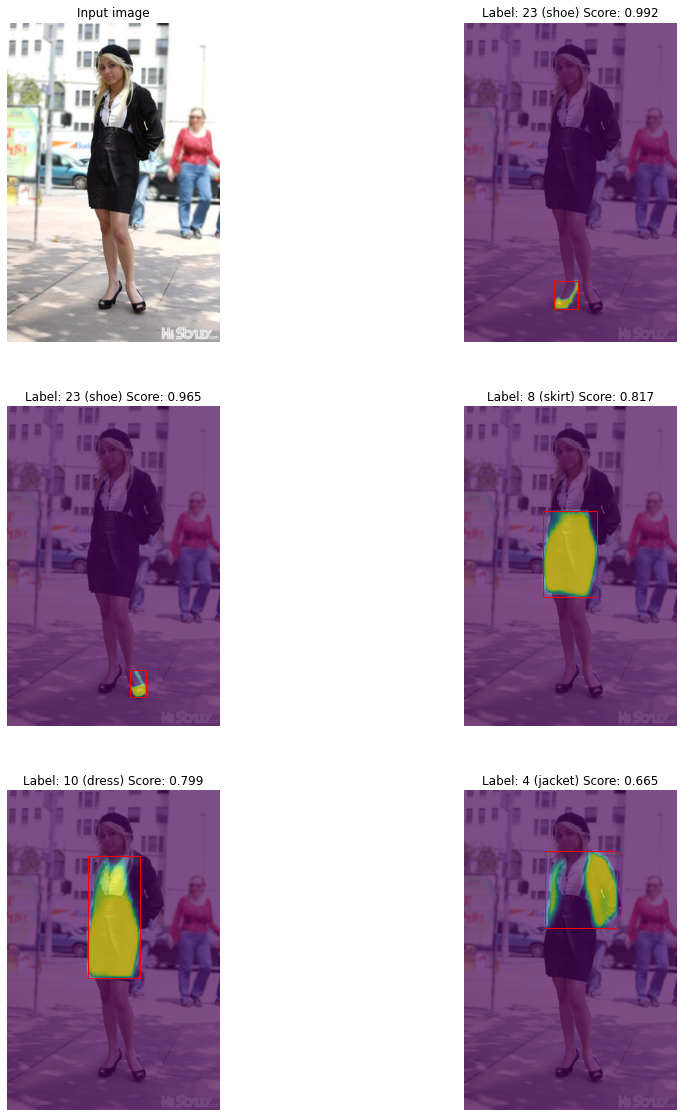

In [0]:
out = filter_data(preds[0], 0.4, categories, keep_labels)
vis_data(
    img.numpy().transpose(1, 2, 0),
    out,
    categories,
    num_cols=2,
    figsize=(15, 20)
)

# Extract embeddings

In [0]:
def create_feature_extractor() -> torch.nn.Module:
    """Create a feature extractor"""
    tmp_model = resnet50(pretrained=True)
    feat_ext = torch.nn.Sequential(*list(tmp_model.children())[:-1])
    for parameter in feat_ext.parameters():
        parameter.requires_grad = False
    return feat_ext.eval()

In [0]:
feat_ext = create_feature_extractor()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
 0%| | 0.00/97.8M [00:00<?, ?B/s]

In [0]:
trans = tvt.Compose(
    [
        tvt.Resize(224),
        tvt.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)

Slow version using CPU for testing

In [0]:
"""Uncomment for testing on CPU, this is slow as molasses

num_imgs = len(inp_ds)
im_idx_list, patch_embeds = [], []
for i, img in tqdm(enumerate(inp_ds), total=num_imgs, unit="images"):
    preds = model([img])
    out = filter_data(preds[0], 0.4, categories, keep_labels)
    for box in out["boxes"]:
        x1, y1, x2, y2 = map(int, box)
        img_patch = img[:, y1:y2, x1:x2]
        feats = feat_ext(trans(img_patch.unsqueeze(0)))
        patch_embeds.append(feats.squeeze())
        im_idx_list.append(i)
"""

Out[17]: '\n# Uncomment for testing on CPU, this is slow as molasses\n\n# num_imgs = len(inp_ds)\n# im_idx_list, patch_embeds = [], []\n# for i, img in tqdm(enumerate(inp_ds), total=num_imgs, unit="images"):\n# preds = model([img])\n# out = filter_data(preds[0], 0.4, categories, keep_labels)\n# for box in out["boxes"]:\n# x1, y1, x2, y2 = map(int, box)\n# img_patch = img[:, y1:y2, x1:x2]\n# feats = feat_ext(trans(img_patch.unsqueeze(0)))\n# patch_embeds.append(feats.squeeze())\n# im_idx_list.append(i)\n'

Faster version using GPU

In [0]:
print(f"Cuda is available: {torch.cuda.is_available()}")
gpu0 = torch.device("cuda:0")
model.to(gpu0);

Cuda is available: True

### Detector inference

In [0]:
def detector_inference(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: str = "cuda:0"
) -> List[torch.tensor]:
    """Run detector inference
    Args:
        model: Segmentation model
        dataloader: Dataset loader
        gpu: Device to perform calculation
    Returns:
        Detected bounding boxes
    """
    model.eval()
    device = torch.device(device)
    model.to(device);
    
    out_boxes = []
    for images in tqdm(dataloader, unit="images"):
        images = [image.to(device) for image in images]
        preds = model(images)
        for pred in preds:
            pred = {k: v.detach().to("cpu") for k, v in pred.items()}
            out = filter_data(pred, 0.4, categories, keep_labels)
            out_boxes.append(out["boxes"].to(torch.int))

    return out_boxes

In [0]:
out_boxes = detector_inference(model, d_l)

0%| | 0/1600 [00:00<?, ?images/s] 0%| | 1/1600 [00:01<38:28, 1.44s/images] 0%| | 2/1600 [00:02<37:25, 1.41s/images] 0%| | 3/1600 [00:03<33:25, 1.26s/images] 0%| | 4/1600 [00:05<31:46, 1.19s/images] 0%| | 5/1600 [00:06<30:42, 1.16s/images] 0%| | 6/1600 [00:06<27:49, 1.05s/images] 0%| | 7/1600 [00:07<27:11, 1.02s/images] 0%| | 8/1600 [00:08<25:37, 1.04images/s] 1%| | 9/1600 [00:09<26:27, 1.00images/s] 1%| | 10/1600 [00:11<29:04, 1.10s/images] 1%| | 11/1600 [00:12<29:00, 1.10s/images] 1%| | 12/1600 [00:13<30:32, 1.15s/images] 1%| | 13/1600 [00:14<27:57, 1.06s/images] 1%| | 14/1600 [00:15<30:00, 1.14s/images] 1%| | 15/1600 [00:16<30:30, 1.15s/images] 1%| | 16/1600 [00:17<29:41, 1.12s/images] 1%| | 17/1600 [00:19<29:22, 1.11s/images] 1%| | 18/1600 [00:20<29:06, 1.10s/images] 1%| | 19/1600 [00:21<29:12, 1.11s/images] 1%|▏ | 20/1600 [00:22<28:23, 1.08s/images] 1%|▏ | 21/1600 [00:23<27:27, 1.04s/images] 1%|▏ | 22/1600 [00:24<27:01, 1.03s/images] 1%|▏ | 23/1600 [00:25<27:19, 1.04s/images] 2%|▏ | 24/1600 [00:26<27:29, 1.05s/images] 2%|▏ | 25/1600 [00:27<27:59, 1.07s/images] 2%|▏ | 26/1600 [00:28<28:19, 1.08s/images] 2%|▏ | 27/1600 [00:29<27:31, 1.05s/images] 2%|▏ | 28/1600 [00:30<28:30, 1.09s/images] 2%|▏ | 29/1600 [00:31<28:00, 1.07s/images] 2%|▏ | 30/1600 [00:32<29:20, 1.12s/images] 2%|▏ | 31/1600 [00:33<28:03, 1.07s/images] 2%|▏ | 32/1600 [00:34<28:12, 1.08s/images] 2%|▏ | 33/1600 [00:35<26:54, 1.03s/images] 2%|▏ | 34/1600 [00:37<28:16, 1.08s/images] 2%|▏ | 35/1600 [00:38<27:55, 1.07s/images] 2%|▏ | 36/1600 [00:39<27:00, 1.04s/images] 2%|▏ | 37/1600 [00:40<26:52, 1.03s/images] 2%|▏ | 38/1600 [00:41<26:54, 1.03s/images] 2%|▏ | 39/1600 [00:42<25:33, 1.02images/s] 2%|▎ | 40/1600 [00:43<28:00, 1.08s/images] 3%|▎ | 41/1600 [00:44<30:44, 1.18s/images] 3%|▎ | 42/1600 [00:45<29:36, 1.14s/images] 3%|▎ | 43/1600 [00:46<28:27, 1.10s/images] 3%|▎ | 44/1600 [00:47<27:11, 1.05s/images] 3%|▎ | 45/1600 [00:48<26:30, 1.02s/images] 3%|▎ | 46/1600 [00:49<26:21, 1.02s/images] 3%|▎ | 47/1600 [00:50<28:17, 1.09s/images] 3%|▎ | 48/1600 [00:52<31:44, 1.23s/images] 3%|▎ | 49/1600 [00:53<30:06, 1.16s/images] 3%|▎ | 50/1600 [00:54<30:27, 1.18s/images] 3%|▎ | 51/1600 [00:56<31:59, 1.24s/images] 3%|▎ | 52/1600 [00:57<30:14, 1.17s/images] 3%|▎ | 53/1600 [00:58<29:23, 1.14s/images] 3%|▎ | 54/1600 [00:59<27:41, 1.07s/images] 3%|▎ | 55/1600 [01:00<29:40, 1.15s/images] 4%|▎ | 56/1600 [01:01<29:27, 1.14s/images] 4%|▎ | 57/1600 [01:02<29:30, 1.15s/images] 4%|▎ | 58/1600 [01:03<29:05, 1.13s/images] 4%|▎ | 59/1600 [01:05<29:55, 1.17s/images] 4%|▍ | 60/1600 [01:06<28:10, 1.10s/images] 4%|▍ | 61/1600 [01:06<26:45, 1.04s/images] 4%|▍ | 62/1600 [01:07<26:47, 1.04s/images] 4%|▍ | 63/1600 [01:09<27:34, 1.08s/images] 4%|▍ | 64/1600 [01:10<27:22, 1.07s/images] 4%|▍ | 65/1600 [01:11<26:49, 1.05s/images] 4%|▍ | 66/1600 [01:12<26:31, 1.04s/images] 4%|▍ | 67/1600 [01:13<29:35, 1.16s/images] 4%|▍ | 68/1600 [01:14<28:50, 1.13s/images] 4%|▍ | 69/1600 [01:16<31:13, 1.22s/images] 4%|▍ | 70/1600 [01:17<29:22, 1.15s/images] 4%|▍ | 71/1600 [01:18<28:56, 1.14s/images] 4%|▍ | 72/1600 [01:19<27:49, 1.09s/images] 5%|▍ | 73/1600 [01:20<27:23, 1.08s/images] 5%|▍ | 74/1600 [01:21<26:31, 1.04s/images] 5%|▍ | 75/1600 [01:22<27:51, 1.10s/images] 5%|▍ | 76/1600 [01:23<30:22, 1.20s/images] 5%|▍ | 77/1600 [01:24<28:30, 1.12s/images] 5%|▍ | 78/1600 [01:25<27:20, 1.08s/images] 5%|▍ | 79/1600 [01:27<29:42, 1.17s/images] 5%|▌ | 80/1600 [01:28<29:52, 1.18s/images] 5%|▌ | 81/1600 [01:29<27:57, 1.10s/images] 5%|▌ | 82/1600 [01:30<29:20, 1.16s/images] 5%|▌ | 83/1600 [01:31<30:49, 1.22s/images] 5%|▌ | 84/1600 [01:32<28:40, 1.14s/images] 5%|▌ | 85/1600 [01:34<30:32, 1.21s/images] 5%|▌ | 86/1600 [01:35<32:22, 1.28s/images] 5%|▌ | 87/1600 [01:37<32:33, 1.29s/images] 6%|▌ | 88/1600 [01:38<30:50, 1.22s/images] 6%|▌ | 89/1600 [01:39<29:36, 1.18s/images] 6%|▌ | 90/1600 [01:40<28:42, 1.14s/images] 6%|▌ | 91/1600 [01:41<31:01, 1.23

### Patch embeddings

In [0]:
def get_embeddings(
    dataset: torch.utils.data.dataset,
    out_boxes: List[torch.tensor]
) -> Tuple[List[int], List[torch.tensor]]:
    """Extract embeddings from image patches
    Args:
        dataset: Dataset of images
        out_boxes: List of detected bounding boxes
    Returns:
        index of input images and respective patch embeddings
    """
    num_imgs = len(dataset)
    im_idx_list, patch_embeds = [], []
    for i, img in tqdm(enumerate(dataset), total=num_imgs, unit="images"):
        for box in out_boxes[i]:
            x1, y1, x2, y2 = box
            img_patch = img[:, y1:y2, x1:x2]
            feats = feat_ext(trans(img_patch.unsqueeze(0)))
            patch_embeds.append(feats.squeeze())
            im_idx_list.append(i)

    return im_idx_list, patch_embeds

In [0]:
im_idx_list, patch_embeds = get_embeddings(inp_ds, out_boxes)

0%| | 0/3200 [00:00<?, ?images/s] 0%| | 1/3200 [00:00<15:41, 3.40images/s] 0%| | 3/3200 [00:00<17:24, 3.06images/s] 0%| | 4/3200 [00:01<14:37, 3.64images/s] 0%| | 5/3200 [00:01<17:07, 3.11images/s] 0%| | 6/3200 [00:02<21:09, 2.52images/s] 0%| | 7/3200 [00:03<34:03, 1.56images/s] 0%| | 8/3200 [00:04<41:14, 1.29images/s] 0%| | 9/3200 [00:04<34:56, 1.52images/s] 0%| | 10/3200 [00:05<33:14, 1.60images/s] 0%| | 11/3200 [00:05<25:55, 2.05images/s] 0%| | 12/3200 [00:05<24:26, 2.17images/s] 0%| | 14/3200 [00:06<21:44, 2.44images/s] 0%| | 15/3200 [00:06<21:20, 2.49images/s] 0%| | 16/3200 [00:07<17:42, 3.00images/s] 1%| | 17/3200 [00:07<19:39, 2.70images/s] 1%| | 18/3200 [00:08<20:59, 2.53images/s] 1%| | 19/3200 [00:08<21:54, 2.42images/s] 1%| | 20/3200 [00:09<24:47, 2.14images/s] 1%| | 21/3200 [00:09<22:48, 2.32images/s] 1%| | 22/3200 [00:10<25:32, 2.07images/s] 1%| | 23/3200 [00:10<26:27, 2.00images/s] 1%| | 24/3200 [00:10<20:21, 2.60images/s] 1%| | 25/3200 [00:10<17:46, 2.98images/s] 1%| | 26/3200 [00:11<19:19, 2.74images/s] 1%| | 27/3200 [00:11<19:22, 2.73images/s] 1%| | 28/3200 [00:12<20:35, 2.57images/s] 1%| | 29/3200 [00:12<21:38, 2.44images/s] 1%| | 30/3200 [00:13<21:50, 2.42images/s] 1%| | 31/3200 [00:13<24:15, 2.18images/s] 1%| | 32/3200 [00:13<21:43, 2.43images/s] 1%| | 33/3200 [00:14<18:01, 2.93images/s] 1%| | 34/3200 [00:14<23:16, 2.27images/s] 1%| | 35/3200 [00:14<19:41, 2.68images/s] 1%| | 37/3200 [00:15<18:03, 2.92images/s] 1%| | 38/3200 [00:16<24:14, 2.17images/s] 1%| | 39/3200 [00:16<22:49, 2.31images/s] 1%|▏ | 40/3200 [00:17<22:09, 2.38images/s] 1%|▏ | 41/3200 [00:17<19:58, 2.63images/s] 1%|▏ | 42/3200 [00:17<22:13, 2.37images/s] 1%|▏ | 43/3200 [00:18<17:55, 2.94images/s] 1%|▏ | 44/3200 [00:18<19:06, 2.75images/s] 1%|▏ | 45/3200 [00:18<19:33, 2.69images/s] 1%|▏ | 46/3200 [00:19<19:37, 2.68images/s] 1%|▏ | 47/3200 [00:19<21:35, 2.43images/s] 2%|▏ | 48/3200 [00:20<26:47, 1.96images/s] 2%|▏ | 49/3200 [00:20<21:12, 2.48images/s] 2%|▏ | 50/3200 [00:21<24:10, 2.17images/s] 2%|▏ | 51/3200 [00:21<25:20, 2.07images/s] 2%|▏ | 52/3200 [00:22<26:17, 2.00images/s] 2%|▏ | 53/3200 [00:22<25:43, 2.04images/s] 2%|▏ | 54/3200 [00:22<19:39, 2.67images/s] 2%|▏ | 55/3200 [00:23<21:57, 2.39images/s] 2%|▏ | 56/3200 [00:23<22:10, 2.36images/s] 2%|▏ | 57/3200 [00:23<17:13, 3.04images/s] 2%|▏ | 58/3200 [00:24<18:46, 2.79images/s] 2%|▏ | 59/3200 [00:24<16:49, 3.11images/s] 2%|▏ | 60/3200 [00:25<18:10, 2.88images/s] 2%|▏ | 61/3200 [00:25<19:14, 2.72images/s] 2%|▏ | 62/3200 [00:25<19:27, 2.69images/s] 2%|▏ | 63/3200 [00:26<20:23, 2.56images/s] 2%|▏ | 64/3200 [00:27<29:13, 1.79images/s] 2%|▏ | 65/3200 [00:27<22:50, 2.29images/s] 2%|▏ | 66/3200 [00:27<20:42, 2.52images/s] 2%|▏ | 67/3200 [00:28<27:46, 1.88images/s] 2%|▏ | 68/3200 [00:28<21:53, 2.38images/s] 2%|▏ | 69/3200 [00:28<19:15, 2.71images/s] 2%|▏ | 70/3200 [00:29<17:46, 2.94images/s] 2%|▏ | 71/3200 [00:29<17:58, 2.90images/s] 2%|▏ | 72/3200 [00:29<16:02, 3.25images/s] 2%|▏ | 73/3200 [00:29<13:07, 3.97images/s] 2%|▏ | 74/3200 [00:30<16:26, 3.17images/s] 2%|▏ | 75/3200 [00:30<18:09, 2.87images/s] 2%|▏ | 76/3200 [00:31<17:16, 3.01images/s] 2%|▏ | 77/3200 [00:31<16:03, 3.24images/s] 2%|▏ | 78/3200 [00:31<15:04, 3.45images/s] 2%|▏ | 79/3200 [00:31<15:51, 3.28images/s] 2%|▎ | 80/3200 [00:32<12:57, 4.02images/s] 3%|▎ | 81/3200 [00:32<14:15, 3.65images/s] 3%|▎ | 82/3200 [00:32<16:45, 3.10images/s] 3%|▎ | 83/3200 [00:33<17:12, 3.02images/s] 3%|▎ | 84/3200 [00:33<14:03, 3.69images/s] 3%|▎ | 85/3200 [00:33<15:22, 3.38images/s] 3%|▎ | 86/3200 [00:33<14:34, 3.56images/s] 3%|▎ | 87/3200 [00:34<13:14, 3.92images/s] 3%|▎ | 88/3200 [00:34<14:41, 3.53images/s] 3%|▎ | 89/3200 [00:34<14:42, 3.52images/s] 3%|▎ | 90/3200 [00:35<20:03, 2.59images/s] 3%|▎ | 91/3200 [00:35<20:58, 2.47images/s] 3%|▎ | 92/3200 [00:36<20:58, 2.47images/s] 3%|▎ | 93/3200 [00:36<23:27, 2.21images/s] 3%|▎ | 94/3200 [00:37<23:04, 2.24images/s] 3%|▎ 

In [0]:
boxes = torch.cat(out_boxes, 0)
print(f"Bounding boxes shape {boxes.shape}")

im_id = np.vstack(im_idx_list).squeeze()
print(f"Image index vector shape: {im_id.shape}")

embeddings = torch.vstack(patch_embeds)
print(f"mbeddings shape:{embeddings.shape}")

Bounding boxes shape torch.Size([14406, 4])
Image index vector shape: (14406,)
mbeddings shape:torch.Size([14406, 2048])

# Cache data

In [0]:
print("Saving data ...")
torch.save(boxes, os.path.join(out_path, "boxes.pt"))
np.save(os.path.join(out_path, "im_id.npy"), im_id)
torch.save(embeddings, os.path.join(out_path, "embeddings.pt"))

Saving data ...

# Load data

In [0]:
""" Uncomment if you want to load the saved data

print("Loading data ...")
boxes = torch.load(os.path.join(out_path, "boxes.pt"))
im_id = np.load(os.path.join(out_path, "im_id.npy"))
embeddings = torch.load(os.path.join(out_path, "embeddings.pt"))
"""

Loading data ...

# Pairwise distance

Naive pairwise distance is calculated for checking. It is slow as molasses.

In [0]:
def get_distances(embeddings: torch.tensor, im_id: np.ndarray) -> torch.tensor:
    """Get pairwise distances
    Args:
        embeddings: Patch embeddings
        im_id: index of input images
    Returns:
        Distances
    """
    norm_emb = normalize(embeddings, p=2.0, dim=1)
    dists = (1.0 - torch.mm(norm_emb, norm_emb.T)) / 2.0

    mask = im_id.reshape(1, -1) == im_id.reshape(-1, 1)
    dists[mask] = 1.0

    return dists

In [0]:
dists = get_distances(embeddings, im_id)
sorted_inds = torch.argsort(dists, 1)

Faster version using dask for distributed computation

In [0]:
def get_distances_fast(
    embeddings: torch.tensor,
    im_id: np.ndarray,
    chunk_size: Tuple[int, int] = (10000, 2048)
) -> np.ndarray:
    """Get pairwise distances
    Args:
        embeddings: Patch embeddings
        im_id: index of input images
        chunk_size: Size of each sub array partition
    Returns:
        Distances
    """
    norm_emb = normalize(embeddings, p=2.0, dim=1)
    tmp_da = da.from_array(norm_emb.numpy(), chunks=chunk_size)
    out = (1.0 - tmp_da.dot(tmp_da.T)) / 2.0
    dists = out.compute()

    mask = im_id.reshape(1, -1) == im_id.reshape(-1, 1)
    dists[mask] = 1.0

    return dists.clip(0.0, 1.0)

In [0]:
# dists = get_distances_fast(embeddings, im_id, chunk_size=(5000, 2048))

# Visualize results

In [0]:
def vis_matches(
    idx: int,
    dataset: torch.utils.data.dataset,
    im_id: np.ndarray,
    sorted_inds: torch.tensor,
    boxes: torch.tensor,
    rank: int = 3,
    num_cols: int = 2,
    figsize: Tuple[int, int] = (15, 10)
) -> None:
    """Visualize the query and top 3 matches
    Args:
        idx: index of image to search
        dataset: Image dataset
        im_id: Index of input images
        sorted_inds: Sorted indexes
        boxes: Patches
        rank: Number of matches to display
        figsize: Figure size
    """
    num_rows = (rank + 1) // num_cols
    fig, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
    ax = ax.flatten()
    fig.suptitle("Image search", fontsize=20)

    for i, tmp_ax in enumerate(ax):
        if i < (rank + 1):
            if i == 0:
                tmp_ax.imshow(dataset[im_id[idx]].numpy().transpose(1, 2, 0))
                tmp_ax.set_title("Search query")
                x1, y1, x2, y2 = boxes[idx]
            else:
                tmp_ax.imshow(
                    dataset[im_id[sorted_inds[idx, i - 1]]].numpy().transpose(1, 2, 0)
                )
                tmp_ax.set_title(f"Match {i}")
                x1, y1, x2, y2 = boxes[sorted_inds[idx, i - 1]]
            rect = patches.Rectangle(
                (x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none'
            )
            tmp_ax.add_patch(rect)
        tmp_ax.axis("off")

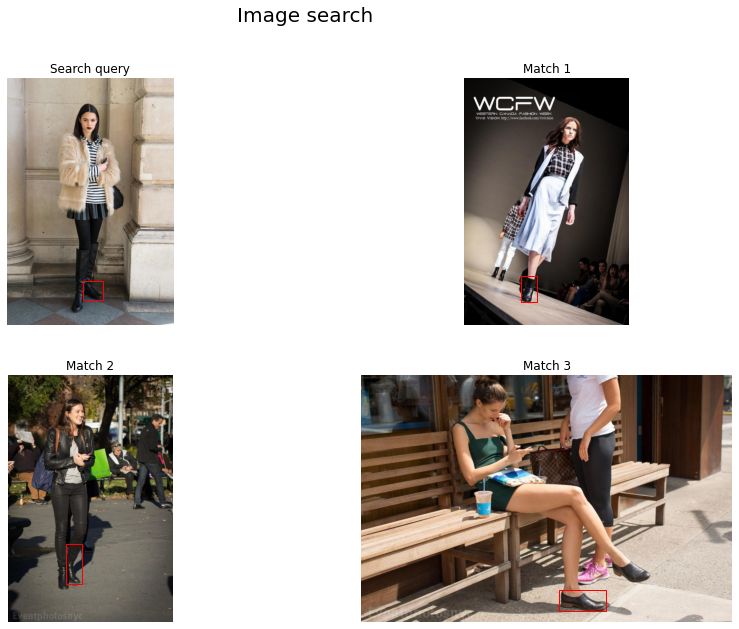

In [0]:
idx = np.random.randint(0, len(im_id))
vis_matches(
    idx,
    inp_ds,
    im_id,
    sorted_inds,
    boxes,
    rank=3,
    num_cols=2,
    figsize=(15, 10)
)